In [1]:
!pip install wget torchinfo

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=9b10132ed7d391d50c9b2a3e087b73ed5d070b702ae22dd6e4970a775de23ac1
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [3]:
!wget -O NCT-CRC-HE-100K.zip https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
!unzip -qq NCT-CRC-HE-100K.zip -d train

print("dataset setup complete!")

--2025-03-23 07:23:12--  https://zenodo.org/record/1214456/files/NCT-CRC-HE-100K.zip
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1214456/files/NCT-CRC-HE-100K.zip [following]
--2025-03-23 07:23:12--  https://zenodo.org/records/1214456/files/NCT-CRC-HE-100K.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 11690284003 (11G) [application/octet-stream]
Saving to: ‘NCT-CRC-HE-100K.zip’

NCT-CRC-HE-100K.zip 100%[===================>]  10.89G  24.8MB/s    in 11m 48s 

2025-03-23 07:35:00 (15.8 MB/s) - ‘NCT-CRC-HE-100K.zip’ saved [11690284003/11690284003]

dataset setup complete!


In [4]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from PIL import Image

from matplotlib import pyplot as plt

import random
import torchvision.transforms.functional as TF

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

In [5]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [6]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [7]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

        self.attention_biases = None
        self.attention_bias_idxs = None

    def compute_attention_bias(self, resolution):

        points = list(itertools.product(range(resolution), range(resolution)))
        N = len(points)

        attention_offsets = {}
        idxs = []

        # if N = 196, then resolution = 14
        for p1 in points:
            for p2 in points:
                offset = (abs(p1[0] - p2[0]), abs(p1[1] - p2[1]))
                if offset not in attention_offsets:
                    attention_offsets[offset] = len(attention_offsets)
                idxs.append(attention_offsets[offset])

        num_offsets = len(attention_offsets)

        # 각 attention head에 대해 num_offsets 만큼의 학습 가능한 Bias를 생성
        self.attention_biases = nn.Parameter(torch.zeros(self.num_heads, num_offsets).to(next(self.parameters()).device))
        self.attention_bias_idxs = torch.LongTensor(idxs).view(N, N).to(next(self.parameters()).device)

    def forward(self, x):
        B, N, C = x.shape
        resolution = int(N ** 0.5)

        if self.attention_biases is None or self.attention_bias_idxs.shape[0] != N:
            self.compute_attention_bias(resolution)

        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # qkv: (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2] # q, k, v: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale # attn: (B, num_heads, N, N)
        attn_bias = self.attention_biases[:, self.attention_bias_idxs].unsqueeze(0) # attn_bias: (1, num_heads, N, N)
        attn = attn + attn_bias
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [9]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [10]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [11]:
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [12]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [13]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [14]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x

In [15]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=9):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=4, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=4, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [88]:
model = LevitDistilled(num_classes=9)
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 5e-4
num_epochs = 30

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [89]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [90]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 9]                   --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [91]:
import torch.nn.init as init

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # CUDA 연산 시 동일한 결과 보장
    torch.cuda.manual_seed_all(seed)  # 멀티-GPU 환경에서 동일한 결과 보장
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 deterministic하게 설정
    torch.backends.cudnn.benchmark = False  # 연산 속도를 희생하고 일관된 연산을 수행

def initialize_weights(m):
    if isinstance(m, nn.Conv2d):  # Conv 레이어 초기화
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):  # Linear 레이어 초기화
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):  # BatchNorm 초기화
        init.constant_(m.weight, 1)
        init.constant_(m.bias, 0)

set_seed(42)  # 랜덤 시드 고정
model.apply(initialize_weights)

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [92]:
train_dir     = './train/NCT-CRC-HE-100K'

In [93]:
# Augmentation
aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.75),
    transforms.RandomVerticalFlip(p=0.75),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [94]:
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

In [95]:
import json

with open("default_index_dict.json", "r") as f:
    index_dict = json.load(f)
load_train_idx = index_dict["train_idx"]
load_val_idx = index_dict["val_idx"]
load_test_idx = index_dict["test_idx"]

In [96]:
#train_data = Subset(dataset, load_train_idx)
#val_data = Subset(dataset, load_val_idx)
#test_data = Subset(dataset, load_test_idx)

dataset_train = datasets.ImageFolder(root=train_dir, transform=aug_transform)
dataset_eval = datasets.ImageFolder(root=train_dir, transform=transform)

train_data = Subset(dataset_train, load_train_idx)
val_data = Subset(dataset_eval, load_val_idx)
test_data = Subset(dataset_eval, load_test_idx)

In [97]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

Train set size: 70000
Validation set size: 15000
Test set size: 15000


In [98]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lr=learning_rate, params=model.parameters())

In [99]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [100]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)

In [101]:
# Global variable to track the best validation loss
best_val_loss = float('inf')

def evaluate(model, data_loader, criterion, device, epoch, phase="Validation", save_path="best_model.pth"):
    global best_val_loss  # Reference global best validation loss
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(data_loader, desc=f"{phase}")):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save all labels and predictions for balanced accuracy
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    balanced_acc = balanced_accuracy_score(all_labels, all_predictions)

    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    # Check if this is the best model so far (lowest validation loss)
    if epoch_loss < best_val_loss:
        best_val_loss = epoch_loss
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved with {phase} loss {epoch_loss:.4f} at {save_path}")

    #return epoch_loss, accuracy, balanced_acc

In [102]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [103]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device, epoch)
    evaluate(model, val_loader, criterion, device, epoch, phase="Validation")


Epoch 1/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.11it/s]


Train Loss: 0.6678, Train Accuracy: 76.10%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]


Validation Loss: 0.3530, Validation Accuracy: 88.29%
Balanced Accuracy: 0.8824
New best model saved with Validation loss 0.3530 at best_model.pth

Epoch 2/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.14it/s]


Train Loss: 0.3445, Train Accuracy: 87.89%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.40it/s]


Validation Loss: 0.3030, Validation Accuracy: 89.57%
Balanced Accuracy: 0.8893
New best model saved with Validation loss 0.3030 at best_model.pth

Epoch 3/30


Training: 100%|██████████| 2188/2188 [02:59<00:00, 12.17it/s]


Train Loss: 0.2352, Train Accuracy: 91.95%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]


Validation Loss: 0.2349, Validation Accuracy: 91.37%
Balanced Accuracy: 0.9075
New best model saved with Validation loss 0.2349 at best_model.pth

Epoch 4/30


Training: 100%|██████████| 2188/2188 [02:59<00:00, 12.19it/s]


Train Loss: 0.1809, Train Accuracy: 93.73%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.45it/s]


Validation Loss: 0.2092, Validation Accuracy: 93.05%
Balanced Accuracy: 0.9325
New best model saved with Validation loss 0.2092 at best_model.pth

Epoch 5/30


Training: 100%|██████████| 2188/2188 [02:59<00:00, 12.20it/s]


Train Loss: 0.1461, Train Accuracy: 95.00%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]


Validation Loss: 0.2037, Validation Accuracy: 92.91%
Balanced Accuracy: 0.9278
New best model saved with Validation loss 0.2037 at best_model.pth

Epoch 6/30


Training: 100%|██████████| 2188/2188 [02:59<00:00, 12.18it/s]


Train Loss: 0.1176, Train Accuracy: 95.94%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s]


Validation Loss: 0.3489, Validation Accuracy: 88.03%
Balanced Accuracy: 0.8759

Epoch 7/30


Training: 100%|██████████| 2188/2188 [02:59<00:00, 12.16it/s]


Train Loss: 0.0951, Train Accuracy: 96.74%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]


Validation Loss: 0.2400, Validation Accuracy: 92.19%
Balanced Accuracy: 0.9235

Epoch 8/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.14it/s]


Train Loss: 0.0757, Train Accuracy: 97.41%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.49it/s]


Validation Loss: 0.4736, Validation Accuracy: 85.91%
Balanced Accuracy: 0.8431

Epoch 9/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.15it/s]


Train Loss: 0.0633, Train Accuracy: 97.88%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]


Validation Loss: 0.0544, Validation Accuracy: 98.11%
Balanced Accuracy: 0.9799
New best model saved with Validation loss 0.0544 at best_model.pth

Epoch 10/30


Training: 100%|██████████| 2188/2188 [02:59<00:00, 12.17it/s]


Train Loss: 0.0546, Train Accuracy: 98.13%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.43it/s]


Validation Loss: 0.7854, Validation Accuracy: 77.95%
Balanced Accuracy: 0.7589

Epoch 11/30


Training: 100%|██████████| 2188/2188 [02:59<00:00, 12.18it/s]


Train Loss: 0.0457, Train Accuracy: 98.46%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.10it/s]


Validation Loss: 0.1298, Validation Accuracy: 95.71%
Balanced Accuracy: 0.9522

Epoch 12/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.15it/s]


Train Loss: 0.0407, Train Accuracy: 98.60%


Validation: 100%|██████████| 469/469 [00:23<00:00, 19.58it/s]


Validation Loss: 1.1383, Validation Accuracy: 76.17%
Balanced Accuracy: 0.7611

Epoch 13/30


Training: 100%|██████████| 2188/2188 [02:59<00:00, 12.21it/s]


Train Loss: 0.0343, Train Accuracy: 98.83%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]


Validation Loss: 0.0965, Validation Accuracy: 97.33%
Balanced Accuracy: 0.9722

Epoch 14/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.13it/s]


Train Loss: 0.0321, Train Accuracy: 98.86%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]


Validation Loss: 0.0951, Validation Accuracy: 97.29%
Balanced Accuracy: 0.9715

Epoch 15/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.15it/s]


Train Loss: 0.0292, Train Accuracy: 99.02%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.15it/s]


Validation Loss: 0.1707, Validation Accuracy: 95.07%
Balanced Accuracy: 0.9516

Epoch 16/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.12it/s]


Train Loss: 0.0248, Train Accuracy: 99.17%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.22it/s]


Validation Loss: 0.3840, Validation Accuracy: 89.27%
Balanced Accuracy: 0.8884

Epoch 17/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.14it/s]


Train Loss: 0.0256, Train Accuracy: 99.13%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]


Validation Loss: 0.2926, Validation Accuracy: 91.49%
Balanced Accuracy: 0.9169

Epoch 18/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.12it/s]


Train Loss: 0.0202, Train Accuracy: 99.33%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]


Validation Loss: 0.0448, Validation Accuracy: 98.45%
Balanced Accuracy: 0.9833
New best model saved with Validation loss 0.0448 at best_model.pth

Epoch 19/30


Training: 100%|██████████| 2188/2188 [03:01<00:00, 12.04it/s]


Train Loss: 0.0177, Train Accuracy: 99.38%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.15it/s]


Validation Loss: 0.0674, Validation Accuracy: 98.21%
Balanced Accuracy: 0.9825

Epoch 20/30


Training: 100%|██████████| 2188/2188 [03:01<00:00, 12.08it/s]


Train Loss: 0.0181, Train Accuracy: 99.40%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]


Validation Loss: 0.0688, Validation Accuracy: 97.82%
Balanced Accuracy: 0.9777

Epoch 21/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.10it/s]


Train Loss: 0.0197, Train Accuracy: 99.35%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.15it/s]


Validation Loss: 0.0361, Validation Accuracy: 98.89%
Balanced Accuracy: 0.9884
New best model saved with Validation loss 0.0361 at best_model.pth

Epoch 22/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.12it/s]


Train Loss: 0.0152, Train Accuracy: 99.49%


Validation: 100%|██████████| 469/469 [00:24<00:00, 18.91it/s]


Validation Loss: 0.0735, Validation Accuracy: 97.61%
Balanced Accuracy: 0.9759

Epoch 23/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.13it/s]


Train Loss: 0.0161, Train Accuracy: 99.46%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.14it/s]


Validation Loss: 0.0368, Validation Accuracy: 98.86%
Balanced Accuracy: 0.9888

Epoch 24/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.13it/s]


Train Loss: 0.0148, Train Accuracy: 99.51%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]


Validation Loss: 0.0388, Validation Accuracy: 98.96%
Balanced Accuracy: 0.9896

Epoch 25/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.12it/s]


Train Loss: 0.0139, Train Accuracy: 99.54%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.39it/s]


Validation Loss: 0.0652, Validation Accuracy: 97.99%
Balanced Accuracy: 0.9789

Epoch 26/30


Training: 100%|██████████| 2188/2188 [03:02<00:00, 12.00it/s]


Train Loss: 0.0126, Train Accuracy: 99.57%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]


Validation Loss: 0.0281, Validation Accuracy: 99.15%
Balanced Accuracy: 0.9912
New best model saved with Validation loss 0.0281 at best_model.pth

Epoch 27/30


Training: 100%|██████████| 2188/2188 [03:01<00:00, 12.07it/s]


Train Loss: 0.0121, Train Accuracy: 99.58%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]


Validation Loss: 0.0646, Validation Accuracy: 98.07%
Balanced Accuracy: 0.9812

Epoch 28/30


Training: 100%|██████████| 2188/2188 [03:01<00:00, 12.02it/s]


Train Loss: 0.0126, Train Accuracy: 99.60%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]


Validation Loss: 0.0356, Validation Accuracy: 98.95%
Balanced Accuracy: 0.9889

Epoch 29/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.09it/s]


Train Loss: 0.0102, Train Accuracy: 99.65%


Validation: 100%|██████████| 469/469 [00:24<00:00, 18.95it/s]


Validation Loss: 0.4774, Validation Accuracy: 88.32%
Balanced Accuracy: 0.8766

Epoch 30/30


Training: 100%|██████████| 2188/2188 [03:00<00:00, 12.10it/s]


Train Loss: 0.0123, Train Accuracy: 99.58%


Validation: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]

Validation Loss: 0.0851, Validation Accuracy: 97.81%
Balanced Accuracy: 0.9791


In [104]:
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [105]:
print("\nFinal Test Evaluation")
evaluate(model,test_loader, criterion, device, epoch, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 469/469 [00:24<00:00, 19.35it/s]


Test Loss: 0.0277, Test Accuracy: 99.05%
Balanced Accuracy: 0.9902
New best model saved with Test loss 0.0277 at best_model.pth


In [106]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 469
Average Time: 12.59 ms
Standard Deviation: 1.13 ms
Maximum Time: 18.61 ms
Minimum Time: 11.73 ms


In [107]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 ampere_sgemm_32x128_tn         0.00%       0.000us         0.00%       0.000us       0.000us       1.367ms        16.29%       1.367ms     170.833us             8  
                                ampere_sgemm_128x128_nn         0.00%       0.000us         0.00%       0.000us       0.000us     991.134us        11.82%     991.134us     123.892us             8  
         

In [108]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc
import torch
import numpy as np
from tqdm import tqdm


def score_evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device) # move tensors to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    overall_f1 = f1_score(all_labels, all_preds, average="macro")
    overall_recall = recall_score(all_labels, all_preds, average="macro")
    overall_precision = precision_score(all_labels, all_preds, average="macro")

    f1_per_class = f1_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    precision_per_class = precision_score(all_labels, all_preds, average=None)
    class_labels = sorted(set(all_labels))

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")


    print(f"Overall - F1: {overall_f1:.4f}, Recall: {overall_recall:.4f}, Precision: {overall_precision:.4f}")
    print("Per-Class Metrics:")
    for i, label in enumerate(class_labels):
        print(f"Class {label} - F1: {f1_per_class[i]:.4f}, Recall: {recall_per_class[i]:.4f}, Precision: {precision_per_class[i]:.4f}")

    return overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class

In [109]:
from sklearn.preprocessing import label_binarize

def roc_auc(model, data_loader, device, num_classes):

    y = ["F1", "Precision", "Recall"]

    model.eval()
    all_labels = []
    all_scores = []

    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc="ROC AUC"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    all_labels = label_binarize(all_labels, classes=list(range(num_classes)))
    print(f"Binarized all_labels shape: {all_labels.shape}")
    print(f"All_scores shape: {np.array(all_scores).shape}")

    fpr, tpr, _ = roc_curve(all_labels.ravel(), np.array(all_scores).ravel())
    roc_auc_value = auc(fpr, tpr)

    plt.figure(figsize=(9, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_value:0.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"Overall ROC AUC: {roc_auc_value:.4f}")

    return fpr, tpr, roc_auc_value

In [110]:
overall_f1, overall_recall, overall_precision, f1_per_class, recall_per_class, precision_per_class = score_evaluate(model, test_loader, criterion, device, phase="Test")

Test: 100%|██████████| 469/469 [00:24<00:00, 19.42it/s]


Test Loss: 0.0277, Test Accuracy: 99.05%
Overall - F1: 0.9904, Recall: 0.9902, Precision: 0.9905
Per-Class Metrics:
Class 0 - F1: 0.9987, Recall: 0.9981, Precision: 0.9994
Class 1 - F1: 0.9991, Recall: 1.0000, Precision: 0.9981
Class 2 - F1: 0.9887, Recall: 0.9884, Precision: 0.9890
Class 3 - F1: 0.9983, Recall: 0.9977, Precision: 0.9988
Class 4 - F1: 0.9899, Recall: 0.9895, Precision: 0.9902
Class 5 - F1: 0.9911, Recall: 0.9906, Precision: 0.9916
Class 6 - F1: 0.9810, Recall: 0.9802, Precision: 0.9817
Class 7 - F1: 0.9786, Recall: 0.9764, Precision: 0.9808
Class 8 - F1: 0.9879, Recall: 0.9912, Precision: 0.9847


<Figure size 2000x1200 with 0 Axes>

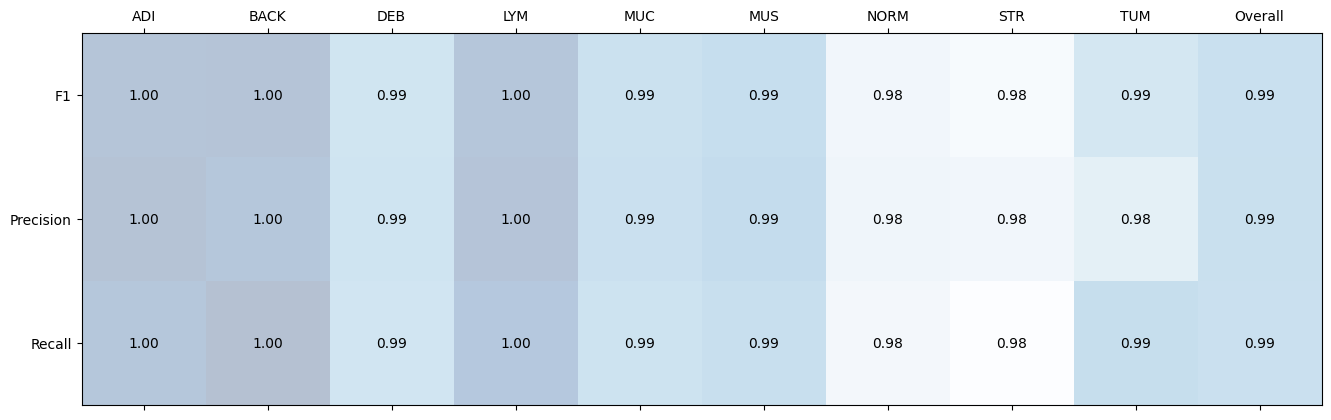

In [111]:
x = ["ADI", "BACK", "DEB", "LYM", "MUC", "MUS", "NORM", 'STR', "TUM"]
y = ["F1", "Precision", "Recall"]

f1_score_list = []
precision_score_list = []
recall_score_list = []

for i, class_name in enumerate(x):
    f1_score_list.append(f1_per_class[i])
    precision_score_list.append(precision_per_class[i])
    recall_score_list.append(recall_per_class[i])

x.append("Overall")
f1_score_list.append(overall_f1)
precision_score_list.append(overall_precision)
recall_score_list.append(overall_recall)

score_list = [f1_score_list, precision_score_list, recall_score_list]
score_list = np.array(score_list)
plt.figure(figsize=(20, 12))
score_cm = plt.matshow(score_list, cmap=plt.cm.Blues, alpha=0.3)
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
for i in range(len(y)):
    for j in range(len(x)):
        # 행렬의 각각의 수치를 각 칸의 중앙에 넣어준다
        plt.text(x=j, y=i,
                     s="{:.2f}".format(score_list[i, j]),
                     va='center',
                     ha='center',
                     )